In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from Features import *



In [34]:
df=pd.read_csv('ReadyData/EURUSD_2020_2023_15M_READY.csv',index_col=0,parse_dates=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98992 entries, 2020-01-02 00:15:00 to 2023-12-20 12:45:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       98992 non-null  float64
 1   high       98992 non-null  float64
 2   low        98992 non-null  float64
 3   close      98992 non-null  float64
 4   volume     98992 non-null  int64  
 5   low_time   98989 non-null  object 
 6   high_time  98989 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 6.0+ MB


# Features and strategy logic

In [36]:
df = rsi(df,'close',14)
df= bollinger_band(df,'close',20, 2) 
df = atr(df,5)
df['hour'] = df.index.hour
df.tail()

df['diff_boll_h'] = df['close'] - df['BB_H']
df['diff_boll_l'] = df['close'] - df['BB_L']
df['diff_boll_m'] = df['close'] - df['BB_M']

# Model developement

In [37]:
# split into train and test data
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [38]:
train['returns'] = np.log(train['close'] / train['close'].shift(1))
train.dropna(inplace=True)
train['direction'] = np.sign(train['returns'])
train['direction'].value_counts()

direction
 1.0    39141
-1.0    38844
 0.0     1186
Name: count, dtype: int64

In [39]:
train.columns

Index(['open', 'high', 'low', 'close', 'volume', 'low_time', 'high_time',
       'RSI', 'BB_M', 'BB_H', 'BB_L', 'ATR', 'hour', 'diff_boll_h',
       'diff_boll_l', 'diff_boll_m', 'returns', 'direction'],
      dtype='object')

In [40]:
features = train[['ATR', 'diff_boll_h','diff_boll_l', 'diff_boll_m']]
target= train['direction']

In [41]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")

lm.fit(features, target)


LogisticRegression(C=1000000.0, max_iter=100000, multi_class='ovr')

In [42]:
train['prediction'] = lm.predict(features)

from sklearn.metrics import accuracy_score
accuracy_score(train['direction'], train['prediction'])

0.6016849604021675

In [43]:
features = test[['ATR', 'diff_boll_h','diff_boll_l', 'diff_boll_m']]

test['prediction'] = lm.predict(features)
test

,open,high,low,close,volume,low_time,high_time,RSI,BB_M,BB_H,BB_L,ATR,hour,diff_boll_h,diff_boll_l,diff_boll_m,prediction
time,,,,,,,,,,,,,,,,,
2023-03-07 07:15:00,1.06892,1.06897,1.06873,1.06886,389,2023-03-07 07:24:00,2023-03-07 07:20:00,54.545455,1.068744,1.069577,1.067911,0.000240,7,-0.000717,0.000949,0.000116,1.0
2023-03-07 07:30:00,1.06886,1.06887,1.06863,1.06869,347,2023-03-07 07:37:00,2023-03-07 07:30:00,36.787565,1.068771,1.069557,1.067985,0.000246,7,-0.000867,0.000705,-0.000081,-1.0
2023-03-07 07:45:00,1.06867,1.06871,1.06813,1.06852,581,2023-03-07 07:57:00,2023-03-07 07:45:00,40.340909,1.068802,1.069485,1.068119,0.000334,7,-0.000965,0.000401,-0.000282,-1.0
2023-03-07 08:00:00,1.06851,1.06868,1.06816,1.06821,694,2023-03-07 08:14:00,2023-03-07 08:00:00,27.272727,1.068817,1.069429,1.068204,0.000362,8,-0.001219,0.000006,-0.000606,-1.0
2023-03-07 08:15:00,1.06818,1.06839,1.06806,1.06826,645,2023-03-07 08:23:00,2023-03-07 08:19:00,34.355828,1.068808,1.069448,1.068168,0.000382,8,-0.001188,0.000092,-0.000548,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20 11:45:00,1.09629,1.09655,1.09628,1.09644,684,2023-12-20 11:45:00,2023-12-20 11:49:00,57.802198,1.096206,1.096996,1.095417,0.000562,11,-0.000556,0.001023,0.000234,1.0
2023-12-20 12:00:00,1.09642,1.09652,1.09591,1.09600,745,2023-12-20 12:09:00,2023-12-20 12:01:00,52.515091,1.096176,1.096947,1.095405,0.000580,12,-0.000947,0.000595,-0.000176,-1.0
2023-12-20 12:15:00,1.09599,1.09624,1.09495,1.09518,818,2023-12-20 12:25:00,2023-12-20 12:17:00,43.816254,1.096106,1.096971,1.095241,0.000706,12,-0.001791,-0.000061,-0.000926,-1.0


In [45]:
df.dropna(inplace=True)
features = df[['ATR', 'diff_boll_h','diff_boll_l', 'diff_boll_m']]

df['prediction'] = lm.predict(features)



# Backtest

In [46]:
position = None
cumulative_profit = 0
trades = []
cost = 0.0001
"""
Ways to imporve the strategy:
1. Time adjustement
2. Multiple entries and calculating average entry price
3. adjustable stop loss and take profit during the trade
"""


for i in range(1, len(df)):
    prev_row = df.iloc[i - 1]
    current_row = df.iloc[i]
    trading_time = current_row['hour'] > 9 and current_row['hour'] < 20
    
    # Slightly relaxed Long Entry Condition
    long_entry =  current_row['prediction'] == 1 and current_row['RSI'] < 40  and trading_time
    short_entry = current_row['prediction'] == -1 and current_row['RSI'] > 60 and trading_time

    #long_exit = current_row['Close'] > current_row['MA']
    #short_exit =  current_row['Close'] < current_row['MA']


    # Check for long entry condition
    if position is None and long_entry:
        entry_price = current_row['close']+cost
        entry_time = df.index[i]  
        tp_price = entry_price + current_row['ATR'] * 5
        sl_price = entry_price - current_row['ATR'] * 3
        position = 'long'
    
    #elif position == 'long' and not (current_row['low'] < sl_price or current_row['high'] > tp_price) and current_row['close'] > entry_price:
    #    sl_price = current_row['close'] - current_row['ATR'] * 3 


    # Check for long exit condition
    elif position == 'long' and (current_row['low'] < sl_price or current_row['high'] > tp_price):
        if current_row['low'] < sl_price and current_row['high'] > tp_price:
            if current_row['low_time'] < current_row['high_time']:
                exit_price = sl_price
            elif current_row['high_time'] < current_row['low_time']:
                exit_price = tp_price
        elif current_row['high'] > tp_price:
            exit_price = tp_price
        elif current_row['low'] < sl_price:
            exit_price = sl_price
        # else if I have exit condition
        #else:
            #exit_price = current_row['close']

        exit_time = df.index[i]  # Capturing the exit time
        pnl = exit_price - entry_price
        cumulative_profit += pnl
        trades.append({'Type': 'Long', 'Entry Price': entry_price, 'Exit Price': exit_price, 'Entry Time': entry_time, 'Exit Time': exit_time, 'PnL': pnl, 'Cumulative Profit': cumulative_profit})
        position = None

    # Check for short entry condition
    elif position is None and short_entry:
        entry_price = current_row['close'] - cost
        entry_time = df.index[i] 
        tp_price = entry_price - current_row['ATR'] * 5
        sl_price = entry_price + current_row['ATR'] * 3
        position = 'short'

    #elif position == 'short' and not (current_row['high'] > sl_price or current_row['low'] < tp_price) and current_row['close'] < entry_price :
    #    sl_price = current_row['close'] + current_row['ATR'] * 3



    # Check for short exit condition
    elif position == 'short' and (current_row['high'] > sl_price or current_row['low'] < tp_price):
        if current_row['high'] > sl_price and current_row['low'] < tp_price:
            if current_row['high_time'] < current_row['low_time']:
                exit_price = sl_price
            elif current_row['low_time'] < current_row['high_time']:
                exit_price = tp_price
        elif current_row['high'] > sl_price:
            exit_price = sl_price
        elif current_row['low'] < tp_price:
            exit_price = tp_price
        # else if I have exit condition
        #else:
           #exit_price = current_row['close']
 
        exit_time = df.index[i]  # Capturing the exit time
        pnl = entry_price - exit_price
        cumulative_profit += pnl
        trades.append({'Type': 'Short', 'Entry Price': entry_price, 'Exit Price': exit_price, 'Entry Time': entry_time, 'Exit Time': exit_time, 'PnL': pnl, 'Cumulative Profit': cumulative_profit})
        position = None
        
# Convert the list of dictionaries to a DataFrame
history_book = pd.DataFrame(trades)


In [47]:
history_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Type               121 non-null    object        
 1   Entry Price        121 non-null    float64       
 2   Exit Price         121 non-null    float64       
 3   Entry Time         121 non-null    datetime64[ns]
 4   Exit Time          121 non-null    datetime64[ns]
 5   PnL                121 non-null    float64       
 6   Cumulative Profit  121 non-null    float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 6.7+ KB


In [48]:
calculate_performance_metrics(history_book)

{'Start Time': '2020-01-13 14:00:00',
 'End Time': '2023-12-05 18:15:00',
 'Win Rate (%)': 0.43,
 'Maximum Drawdown (pips)': 0.0266,
 'Average Drawdown (pips)': 0.0086,
 'Maximum Drawdown Duration': '453 days 05:30:00',
 'Average Drawdown Duration': '100 days 15:06:49',
 'Total Number of Trades': 121,
 'Buy Count': 74,
 'Sell Count': 47,
 'Total Profit (pips)': 486.54,
 'Average Time in Trade': '0 days 14:04:20',
 'Average win': 0.0042,
 'Average loss': -0.0024}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


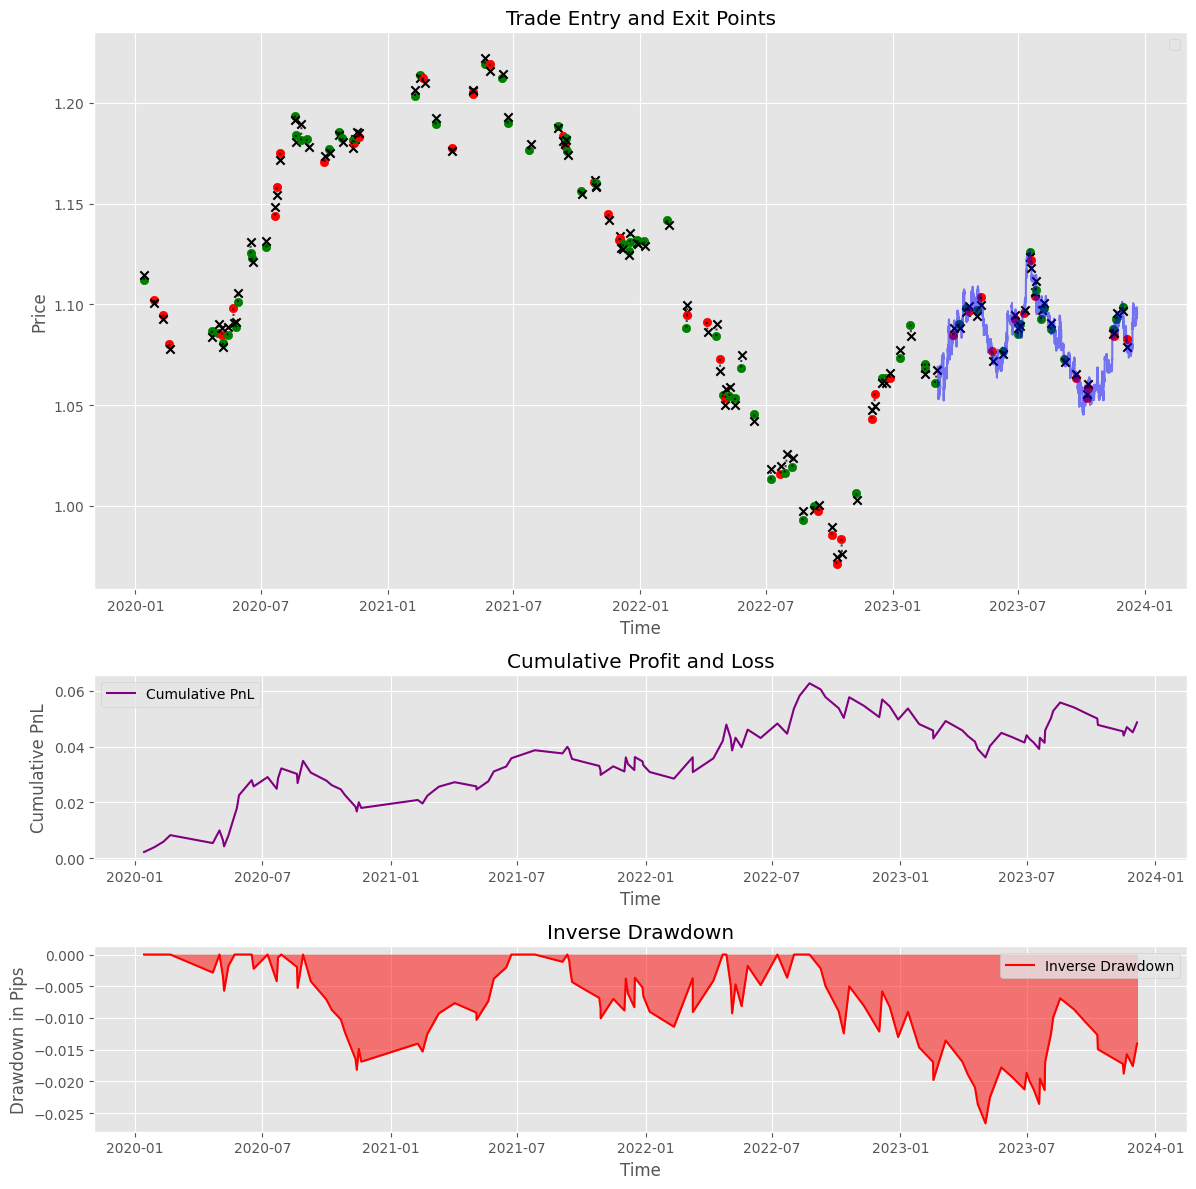

In [50]:
plot_trades(history_book,test)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


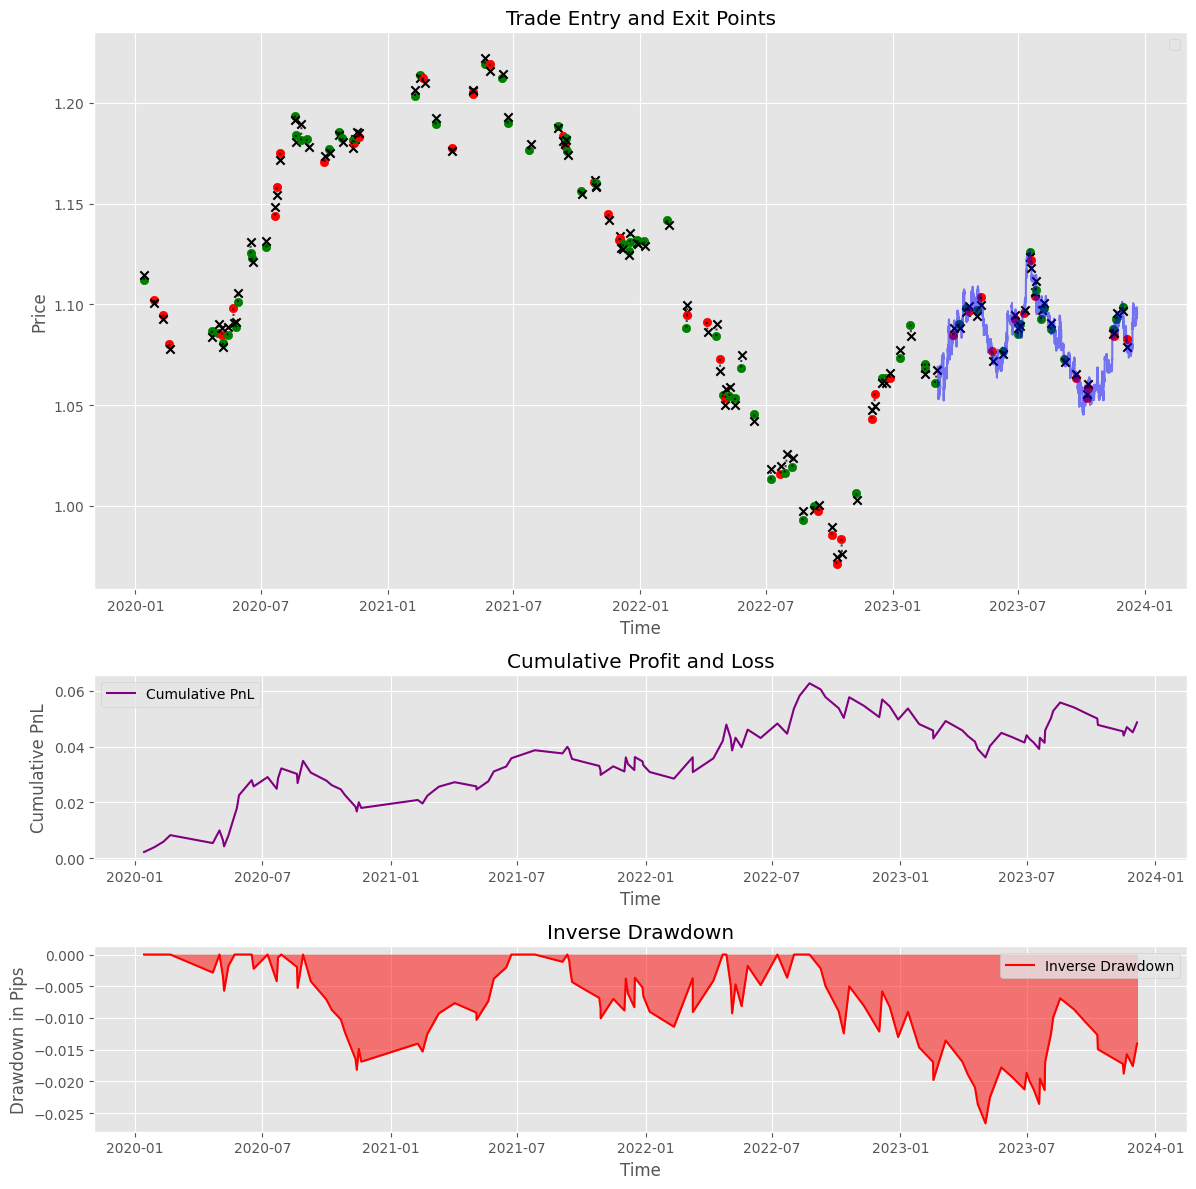

In [51]:
plot_trades(history_book,test)

In [43]:
history_book

,Type,Entry Price,Exit Price,Entry Time,Exit Time,PnL,Cumulative Profit
0,Short,1.05076,1.052266,2023-10-16 00:20:00,2023-10-16 01:10:00,-0.001506,-0.001506
1,Long,1.05600,1.055454,2023-10-17 00:55:00,2023-10-17 02:15:00,-0.000546,-0.002052
2,Short,1.05363,1.054158,2023-10-19 03:10:00,2023-10-19 04:05:00,-0.000528,-0.002580
3,Long,1.06051,1.055980,2023-10-19 19:00:00,2023-10-19 19:35:00,-0.004530,-0.007110
4,Long,1.05831,1.057812,2023-10-20 00:50:00,2023-10-20 03:15:00,-0.000498,-0.007608
5,Long,1.06698,1.067950,2023-10-24 03:10:00,2023-10-24 05:15:00,0.000970,-0.006638
6,Long,1.06846,1.067488,2023-10-24 09:00:00,2023-10-24 10:30:00,-0.000972,-0.007610
7,Short,1.05332,1.055324,2023-10-26 15:20:00,2023-10-26 15:50:00,-0.002004,-0.009614
8,Long,1.06165,1.061260,2023-10-31 00:55:00,2023-10-31 01:55:00,-0.000390,-0.010004
9,Short,1.05763,1.056510,2023-11-01 03:05:00,2023-11-01 10:35:00,0.001120,-0.008884
